This notebook best viewed here: https://nbviewer.jupyter.org

<a id='home'></a>
This notebook is for the Jack pine GEA mapping pops

#### Purpose
• I've run the baypass commands across four servers, I need to gather the jobs and concatenate results.

#### Notebook outline

1. [rsync files from servers](#rsync)
    - I execute the rsync commands to transfer files from the executing servers to our lab server
1. [ensure complete transfer](#ensure)
    - given the number of gfiles and chains, make sure all of the commands have been executed/transferred

1. [gather all of the wanted resfiles and concat into single dataframes](#combine)
    - gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe
    
    
1. [rank loci](#rank)
    - Rank each locus for each chain by descending BF(dB) score
    - Caclulate mean BF(dB) across 5 chains, rank each locus based on mean
    - Create boolean column with True if locus is ranked in top 1% for at least 3/5 chains
    - Create boolean column with True if locus has BF(dB) >= 15 for at least 3/5 chains
    - Create boolean column with True if locus has BF(dB) >= 20 for at least 3/5 chains
    
1. [look at BF scores for consistent top 1% ranks](#consistent)
    - explore the top 1% of ranks
    - count number of SNPs >= BF(dB) thresholds {15, 20}, print if not all SNPs >= thresh are consistently in top 1% across chains

In [1]:
from pythonimports import *
lview,dview = get_client()

56 56


In [2]:
# dir names
baydir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'
cmddir = op.join(baydir, 'cmd_files')
rundir = op.join(cmddir, 'run_01')
gfile_dir = op.join(baydir, 'individual_gfiles')
shdir = op.join(cmddir, 'shfiles')
resdir = op.join(cmddir, 'results')
assert op.exists(resdir)
rsyncdir = makedir(op.join(baydir, 'rsync_files'))

<a id='rsync'></a>
# rsync files from servers

[top](#home)

In [3]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit b1d8bd7312fbf3c6afef4ad9ea2585831ec509a5
Author: Brandon Lind <lindb@vcu.edu>
Date:   Fri Feb 12 12:21:51 2021 -0500
Today:	February 25, 2021 - 11:26:07
python version: 3.8.5
##################################################################



In [4]:
def submit_cmds(cmds):
    """Execute a list of system commands in parallel. Return cmd if there was an error."""
    jobs = []
    for cmd in nb(cmds):
        *args, src, dst = cmd.split()
        jobs.append(lview.apply_async(rsync, *(src, dst)))
    watch_async(jobs)
    
    badcmds = []
    for i,j in enumerate(jobs):
        try:
            x=j.r
            assert 'speedup' in ' '.join(x)
        except:
            badcmds.append(cmds[i])
    print('len(badcmds) = ', len(badcmds))
    
    return badcmds

In [5]:
def check_realfiles(cmds, new=False):
    """Make sure all transferred files exist.
    new is used if transferring the results from SNPs that were once REPEATS (NA for Jack pine)
    """
    realfiles = []
#     if new is True:
#         rundir = newrundir
#         gfile_dir = newgfiledir
#         shdir = newshdir
#         resdir = newresdir
    for d in [rundir, gfile_dir, shdir, resdir]:
        realfiles.extend(fs(d, dirs=False))
    
    expfiles = []
    for cmd in cmds:
        expfiles.append(cmd.split()[-1])
    
    print('len(realfiles) = ', len(realfiles))
    print('len(expfiles) =', len(expfiles))
    
    needed = list(set(expfiles) - set(realfiles))
#     return needed
    
    print('needed = ', len(needed))
    
    needed_cmds = []
    for n in needed:
        for cmd in cmds:
            if n in cmd:
                needed_cmds.append(cmd)
    print('needed_cmds = ', len(needed_cmds))
    return needed_cmds

#### cedar cmds

In [6]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass'

In [7]:
cmds = read(op.join(baydir, 'cedar_rsync_cmds.txt'))
len(cmds)

37639

In [8]:
dirs = []
for cmd in cmds:
    newfile = cmd.split()[-1]
    dname = op.dirname(newfile)
    dirs.append(dname)
for d in uni(dirs):
    assert op.exists(d)
d

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/cmd_files/results'

In [11]:
for cmd in pbar(cmds):
    assert 'without_p24' in cmd

100%|██████████| 37639/37639 [00:00<00:00, 2447473.89it/s]


In [13]:
*args, src, dst = cmds[0].split()
rsync(src, dst)

['receiving incremental file list',
 '',
 'sent 20 bytes  received 99 bytes  34.00 bytes/sec',
 'total size is 104  speedup is 0.87',
 '']

In [14]:
badcmds = submit_cmds(cmds)

100%|██████████| 37639/37639 [01:39<00:00, 380.06it/s]



Watching 37639 jobs ...


100%|██████████| 37639/37639 [1:26:52<00:00,  7.22it/s]   


len(badcmds) =  14


In [15]:
len(badcmds)

14

In [18]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  40780
len(expfiles) = 37639
needed =  1
needed_cmds =  1


1

In [19]:
badcmds = submit_cmds(needed)

100%|██████████| 1/1 [00:00<00:00, 419.43it/s]



Watching 1 jobs ...


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

len(badcmds) =  1


In [20]:
needed = check_realfiles(cmds)
len(needed)

len(realfiles) =  40780
len(expfiles) = 37639
needed =  1
needed_cmds =  1


1

In [21]:
# this was because watcher.sh is actually baypass_watcher.sh
badcmds

['rsync -avz cedar:/scratch/lindb/jp_gea/cmd_files/shfiles/watcher.sh /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/cmd_files/shfiles/watcher.sh']

<a id='ensure'></a>
# ensure complete transfer
given the number of gfiles and chains, make sure all of the commands have been executed/transferred

[top](#home)

#### first check to make sure every sh file was exececuted (ie, check that each has a slurm .out file)

In [24]:
# the the shfiles and out files
shfiles = fs(shdir, endswith='.sh', exclude='watcher')
outs = fs(shdir, endswith='.out', exclude='watcher')
len(shfiles), len(outs)

(156, 156)

In [25]:
# which sh files were not run, print out any that weren't run
pairs = {}
for sh in shfiles:
    pairs[sh] = []
    for out in outs:
        if op.basename(sh).split(".")[0] in out:
            pairs[sh].append(out)
needed = []
for sh,outfiles in pairs.items():
    if len(outfiles) < 1:
        print(sh, len(outfiles))
        needed.append(sh)
len(needed)

0

#### go through catfiles and make sure all of the commands inside were run

In [26]:
resdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/cmd_files/results'

In [27]:
# get one of the files for each of the commands that executed successfully (count the succesful cmds)
resfiles = fs(resdir, endswith='DIC.out')
len(resfiles)

7465

In [28]:
# get the files with the baypass commands - this matches number of sh files (good)
catfiles = fs(rundir, pattern='catfile')
len(catfiles)

156

In [29]:
# iterate through catfile commands and make sure there's a result for each
found = {}  # map prefix to output file
exe = {}  # map prefix to command used
needed_catfiles = []
catcount = Counter()
cmdcats = {}  # map cmds to catfiles
for cat in nb(catfiles):
    # get the commands
    cmds = read(cat)
    
    # assign prefixes (= num cmds) to their output
    notfound = True
    for cmd in cmds:
        assert cmd not in cmdcats
        cmdcats[cmd] = cat
        prefix = cmd.split("-outprefix")[1].split()[0]
        assert prefix not in found and 'chain' in prefix
        exe[prefix] = cmd
        found[prefix] = []
        for res in resfiles:
            if prefix in op.basename(res):
                found[prefix].append(res)
        if len(found[prefix]) > 0:
            notfound = False
            catcount[cat] += 1
    if notfound is True:
        needed_catfiles.append(cat)
            
prefix

100%|██████████| 156/156 [00:35<00:00,  4.35it/s]


'all_snps_ADP-lt-1000_gfile_1492_chain_5'

In [30]:
len(needed_catfiles)

0

In [31]:
Counter(catcount.values())

Counter({48: 155, 25: 1})

In [32]:
needed_catfiles

[]

In [33]:
# figure out which prefixes have zero output (and need to be reran) or cmds with >1 output (impossible...)
needed_cmds = []
for prefix,reslist in found.items():
    if len(reslist) == 0:
        needed_cmds.append(exe[prefix])  # get the cmd that needs to be executed
    elif len(reslist) > 1:
        print('\n', prefix, len(reslist))  # this shouldn't be possible, check anyway, print if so
len(needed_cmds)

0

In [34]:
cats = []
for cmd in needed_cmds:
    cats.append(cmdcats[cmd])

In [35]:
luni(cats)

0

In [36]:
for cat in suni(cats):
    print(cat, catcount[cat])

<a id='combine'></a>
# gather all of the wanted resfiles and concat into single dataframes

gather the files with BF, label SNP IDs, label environmental covariables, and concat into single dataframe

[top](#home)

In [ ]:
# restart notebook

In [51]:
import seaborn as sns

latest_commit()
sinfo(html=True)

##################################################################
Current commit of pythonimports:
commit 3a4b7edd94791192e01088623ade64a0a79f4b39
Author: Brandon Lind <lindb@vcu.edu>
Date:   Tue Mar 23 14:07:40 2021 -0400
Today:	April 12, 2021 - 16:45:16
python version: 3.8.5
##################################################################



In [4]:
bffiles = fs(resdir, endswith='betai_reg.out')
xtxfiles = fs(resdir, endswith='pi_xtx.out')
len(bffiles), len(xtxfiles)

(7465, 7465)

In [5]:
bf = pd.read_table(bffiles[0], delim_whitespace=True)
bf.head()

,COVARIABLE,MRK,M_Pearson,SD_Pearson,BF(dB),Beta_is,SD_Beta_is,eBPis
0,1,1,0.055431,0.149737,-8.936432,0.004304,0.008930,0.200794
1,1,2,-0.124197,0.130715,-8.395409,-0.006371,0.006360,0.499656
2,1,3,0.190502,0.132185,-3.330409,0.011729,0.008653,0.756335
3,1,4,0.130658,0.128184,-9.464144,0.006851,0.006019,0.593427
4,1,5,0.091650,0.134789,-6.974807,0.006382,0.009485,0.300124


In [6]:
xtx = pd.read_table(xtxfiles[0], delim_whitespace=True)
xtx.head()

,MRK,M_P,SD_P,M_XtX,SD_XtX,XtXst,log10(1/pval)
0,1,0.830735,0.113523,38.864899,8.871848,35.666033,0.205689
1,2,0.898133,0.067479,38.381309,8.587412,61.591387,1.920094
2,3,0.817982,0.096432,39.080378,8.479784,75.507596,3.390954
3,4,0.907727,0.065619,37.986434,8.603630,64.249962,2.178118
4,5,0.765655,0.115483,39.811275,8.563068,69.333585,2.703233


In [7]:
def label_snps(resfile):
    """Label baypass resfiles with SNP ID using pkl files saved in 002_kickoff."""
    import os
    import pandas
    # find the gfile associated with resfile
    prefix = os.path.basename(resfile).split("_chain")[0]
    chain = "chain_%s" % os.path.basename(resfile).split(prefix)[1].split("_")[2]
    
    # get the pkl file that has the ordered list of SNP IDs for the gfile
    if 'new' in resfile:
        newgfile_dir = os.path.dirname(resfile).replace("new_results", "new_individual_gfiles")
        pklfile = os.path.join(newgfile_dir, f'{prefix}_noheaderidx.pkl')
    else:
        pklfile = os.path.join(gfile_dir, f'{prefix}_noheaderidx.pkl')
    gloci = pklload(pklfile)  # read in rows with SNPIDs, but only one column
    
    # read in the resfile
    df = pandas.read_table(resfile, delim_whitespace=True)
    
    # map MRK column (SNP index) to locus name
    gdict = dict((num+1, locus) for num,locus in enumerate(gloci))
    
    # map covariable column to environment ID
    edict = dict((num+1, env) for num,env in enumerate(efile.index))
    
    # split each covariable (env) in to its own file, label index with SNP ID
    df['env'] = df['COVARIABLE'].map(edict)
    envdfs = {chain:{}}
    for env in uni(df['env']):
        envdfs[chain][env] = df[df['env']==env].copy()
        envdfs[chain][env].index = envdfs[chain][env]['MRK'].map(gdict)
        envdfs[chain][env].index.names = ['']

    return envdfs

efile = pd.read_table(op.join(baydir, 'efile_std_HEADERIDX.txt'), index_col=0, usecols=[0,1])
dview['efile'] = efile
dview['uni'] = uni
dview['gfile_dir'] = gfile_dir
dview['pklload'] = pklload

In [8]:
# label SNP IDs in parallel
jobs = []
for bffile in pbar(bffiles):
    jobs.append(lview.apply_async(label_snps, bffile))
watch_async(jobs)

100%|██████████| 7465/7465 [00:06<00:00, 1193.26it/s]



Watching 7465 jobs ...


100%|██████████| 7465/7465 [12:49<00:00,  9.70it/s]


In [9]:
# gather output by environment
envlist = {}
for j in nb(jobs):
    if j.ready():
        chain = keys(j.r)[0]
        if chain not in envlist:
            envlist[chain] = {}
        for env in j.r[chain]:
            if env not in envlist[chain]:
                envlist[chain][env] = []
            envlist[chain][env].append(j.r[chain][env])
keys(envlist)

100%|██████████| 7465/7465 [00:00<00:00, 18269.71it/s]


['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [10]:
# concatenate environmental output by each chain, print out num snps for each env for each chain
chaindfs = {}
for chain,envs in envlist.items():
    assert len(envs) == 19
    if chain not in chaindfs:
        chaindfs[chain] = {}
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in chaindfs[chain]:
            chaindfs[chain][env] = pd.concat(dfs)
        else:
            print('crap ', chain, env)
for chain in chaindfs:
    print(ColorText(chain).bold())
    for env in chaindfs[chain]:
        print('\t',env, nrow(chaindfs[chain][env]))

chain_5: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]

chain_1
	 Eref 2239048
	 DD_0 2239048
	 CMD 2239048
	 SHM 2239048
	 PAS 2239048
	 bFFP 2239048
	 MAP 2239048
	 EMT 2239048
	 EXT 2239048
	 AHM 2239048
	 NFFD 2239048
	 TD 2239048
	 DD5 2239048
	 FFP 2239048
	 eFFP 2239048
	 MSP 2239048
	 MAT 2239048
	 MWMT 2239048
	 MCMT 2239048
chain_2
	 SHM 2239048
	 CMD 2239048
	 DD5 2239048
	 bFFP 2239048
	 FFP 2239048
	 eFFP 2239048
	 TD 2239048
	 MWMT 2239048
	 DD_0 2239048
	 MSP 2239048
	 EMT 2239048
	 MAP 2239048
	 MCMT 2239048
	 Eref 2239048
	 NFFD 2239048
	 AHM 2239048
	 MAT 2239048
	 EXT 2239048
	 PAS 2239048
chain_3
	 CMD 2239048
	 MSP 2239048
	 MAT 2239048
	 MCMT 2239048
	 FFP 2239048
	 DD5 2239048
	 eFFP 2239048
	 MAP 2239048
	 EMT 2239048
	 AHM 2239048
	 TD 2239048
	 bFFP 2239048
	 Eref 2239048
	 NFFD 2239048
	 MWMT 2239048
	 DD_0 2239048
	 EXT 2239048
	 SHM 2239048
	 PAS 2239048
chain_4
	 TD 2239048
	 DD_0 2239048
	 MAT 2239048
	 MSP 2239048
	 SHM 2239048
	 eFFP 2239048
	 FFP 2239048
	 MWMT 2239048
	 Eref 2239048
	 bFFP 2239048
	 AHM 22

In [11]:
# concatenate environmental output by each env, combine chains into single df
dflst = {}
for chain,envs in envlist.items():
    for env,dfs in nb(envs.items(), desc=chain):
        if env not in dflst:
            dflst[env] = []
        df = pd.concat(dfs)
        df.columns = [f"{chain}-{col}" for col in df.columns]
        dflst[env].append(df)
# combine chains for each env - should have done this in parallel
envdfs = {}
for env,lst in nb(dflst.items(), desc='combo'):
    assert len(lst) == 5
    df = pd.merge(lst[0], lst[1], left_index=True, right_index=True)
    df2 = pd.merge(lst[2], lst[3], left_index=True, right_index=True)
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    envdfs[env] = pd.merge(df3, lst[4], left_index=True, right_index=True)
    
    
envdfs[env].head()           

combo: 100%|██████████| 19/19 [03:05<00:00,  9.77s/it]


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
>super4-15421,11,1,-0.025729,0.144556,-9.754825,-0.003042,0.009956,0.119233,MCMT,11,1,-0.035898,0.145169,-9.410429,-0.003916,0.010435,0.150303,MCMT,11,1,-0.026291,0.145643,-9.248764,-0.003225,0.010542,0.119361,MCMT,11,1,-0.033599,0.147603,-9.266665,-0.003771,0.010485,0.143196,MCMT,11,1,-0.027187,0.143263,-9.226468,-0.003423,0.010562,0.127334,MCMT
>super4-47333,11,2,0.029974,0.138354,-10.246416,0.002228,0.007624,0.113470,MCMT,11,2,0.036888,0.136751,-11.261825,0.002768,0.007826,0.140528,MCMT,11,2,0.037494,0.139667,-11.058011,0.002723,0.007882,0.136850,MCMT,11,2,0.046759,0.143013,-10.685924,0.003215,0.008097,0.160309,MCMT,11,2,0.040987,0.140133,-10.811931,0.003096,0.007896,0.158043,MCMT
>super4-47418,11,3,-0.109512,0.125799,-8.771552,-0.007515,0.009099,0.388436,MCMT,11,3,-0.112168,0.128415,-7.914224,-0.007927,0.009520,0.392509,MCMT,11,3,-0.108819,0.125919,-8.931330,-0.007622,0.009216,0.389112,MCMT,11,3,-0.114038,0.124878,-8.815074,-0.008017,0.009175,0.417689,MCMT,11,3,-0.112229,0.122674,-8.372039,-0.007825,0.009048,0.412096,MCMT
>super4-47461,11,4,-0.150286,0.133548,-6.517485,-0.008806,0.007467,0.622846,MCMT,11,4,-0.152461,0.134123,-3.939702,-0.008563,0.006876,0.671619,MCMT,11,4,-0.150226,0.133223,-6.617081,-0.008722,0.007337,0.629792,MCMT,11,4,-0.151588,0.131741,-6.369249,-0.008764,0.007052,0.669707,MCMT,11,4,-0.142432,0.130794,-6.297588,-0.008363,0.007179,0.612518,MCMT
>super4-47513,11,5,-0.076260,0.128904,-8.699308,-0.006081,0.010377,0.253458,MCMT,11,5,-0.078822,0.130434,-9.349220,-0.006168,0.010369,0.258105,MCMT,11,5,-0.077370,0.130829,-8.988745,-0.005943,0.010284,0.249250,MCMT,11,5,-0.079200,0.128224,-9.165058,-0.006157,0.010145,0.264493,MCMT,11,5,-0.077598,0.128749,-9.103266,-0.006052,0.010270,0.255181,MCMT


In [12]:
# how many SNPs should be in each env file?
# read in each of the gfiles and sum rows
rows = 0
for gfile in nb(fs(gfile_dir, pattern='noheaderidx.txt')):
    df = pd.read_table(gfile, usecols=[0], header=None)
    rows += nrow(df)
rows

100%|██████████| 1493/1493 [00:06<00:00, 234.35it/s]


2239048

In [13]:
# assert each env has the expected number of rows (SNPs)
for env in envdfs:
    print(ColorText(env).bold())
    print('\t',env, nrow(envdfs[env]))
    if nrow(envdfs[env]) != rows:
        print(ColorText('CRAAAAAAAAAP').fail().bold())

Eref
	 Eref 2239048
DD_0
	 DD_0 2239048
CMD
	 CMD 2239048
SHM
	 SHM 2239048
PAS
	 PAS 2239048
bFFP
	 bFFP 2239048
MAP
	 MAP 2239048
EMT
	 EMT 2239048
EXT
	 EXT 2239048
AHM
	 AHM 2239048
NFFD
	 NFFD 2239048
TD
	 TD 2239048
DD5
	 DD5 2239048
FFP
	 FFP 2239048
eFFP
	 eFFP 2239048
MSP
	 MSP 2239048
MAT
	 MAT 2239048
MWMT
	 MWMT 2239048
MCMT
	 MCMT 2239048


In [14]:
# release some RAM
del dflst, chaindfs, df, df2, df3, dfs, envlist, jobs

# reduce to only non-paralog non-repeat

when I had originally filtered out JP_p24, I accidently didn't remove PARALOGS and REPEATS.

I went back and redid this after baypass had finished, so here I just subset the baypass outputs to those SNPs. I do it here so I can confirm expected returns from baypass, but before ranking across loci done below.

The refiltered file contains the exact information for non-paralog/non-repeat SNPs as the old file. The refiltered file was given the name as the old file, and the old filename was appended to end with `_old.txt`

The rankings before removing paralog and repeat snps are in baypass/final_results/with_paralogs_and_repeats

In [16]:
# this is the refiltered file
snps = parallel_read(op.join(op.dirname(baydir), 'JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt'),
                     lview=lview, verbose=False)

# assert that ADP of any loci that aren't in baypass output have ADP >= 1000
notin = snps[~snps['unstitched_locus'].isin(envdfs[env].index)].copy()
print('\nnumber excluded =', nrow(notin))
assert notin['ADP'].min() >= 1000

snps.head()


Watching 56 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|██████████| 56/56 [00:12<00:00,  4.51it/s]


Function `parallel_read` completed after : 0-00:00:30


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,JP_p14.PVAL,JP_p14.AD,JP_p14.RD,JP_p70.GT,JP_p70.GQ,JP_p70.SDP,JP_p70.DP,JP_p70.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
0,Scaffold_1,15421,A,G,0.670204,-10.0,SNP,PASS,22,0,32,8,0,A/G,67.0,22.0,22.0,72.73%,1.790500e-07,16.0,6.0,G/G,126.0,32.0,32.0,84.38%,2.378500e-13,27.0,5.0,A/G,87.0,26.0,26.0,76.92%,1.827300e-09,20.0,6.0,A/G,30.0,14.0,14.0,57.14%,9.661800e-04,8.0,6.0,A/G,90.0,32.0,32.0,68.75%,...,15.0,80%,5.260500e-06,12.0,3.0,A/G,21.0,12.0,12.0,50%,6.865000e-03,6.0,6.0,A/G,97.0,28.0,28.0,78.57%,1.758300e-10,22.0,6.0,G/G,49.0,13.0,13.0,84.62%,1.009600e-05,11.0,2.0,A/G,38.0,26.0,26.0,42.31%,1.279100e-04,11.0,15.0,A/G,47.0,19.0,19.0,63.16%,1.861100e-05,12.0,7.0,Scaffold_1-15421,>super4,15421,>super4-15421,0.329796
1,Scaffold_1,47333,G,A,0.108624,-10.0,SNP,PASS,109,7,33,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G/A,34.0,121.0,121.0,9.09%,3.850000e-04,11.0,110.0,G/A,58.0,85.0,85.0,21.18%,1.395700e-06,18.0,67.0,G/A,34.0,133.0,133.0,8.27%,3.936900e-04,11.0,122.0,G/A,50.0,118.0,118.0,13.56%,...,44.0,18.18%,2.757300e-03,8.0,36.0,G/A,21.0,77.0,77.0,9.09%,6.775500e-03,7.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G/A,44.0,103.0,103.0,13.59%,3.802900e-05,14.0,89.0,G/G,250.0,134.0,134.0,0%,1.000000e+00,0.0,134.0,G/A,27.0,105.0,105.0,8.57%,1.633500e-03,9.0,96.0,Scaffold_1-47333,>super4,47333,>super4-47333,0.108624
2,Scaffold_1,47418,T,A,0.220805,-10.0,SNP,PASS,113,2,38,0,0,T/A,45.0,70.0,70.0,20%,2.968700e-05,14.0,56.0,T/A,83.0,140.0,140.0,18.57%,4.146600e-09,26.0,114.0,T/A,82.0,97.0,97.0,25.77%,5.045400e-09,25.0,72.0,T/A,94.0,137.0,137.0,21.17%,3.550500e-10,29.0,108.0,T/A,117.0,126.0,126.0,27.78%,...,44.0,15.91%,6.036300e-03,7.0,37.0,T/A,51.0,89.0,89.0,17.98%,7.216200e-06,16.0,73.0,T/A,71.0,112.0,112.0,19.64%,7.603100e-08,22.0,90.0,T/A,71.0,102.0,102.0,21.57%,6.704300e-08,22.0,80.0,T/A,37.0,121.0,121.0,9.92%,1.833300e-04,12.0,109.0,T/A,67.0,122.0,122.0,17.21%,1.861000e-07,21.0,101.0,Scaffold_1-47418,>super4,47418,>super4-47418,0.220805
3,Scaffold_1,47461,T,G,0.082141,-10.0,SNP,PASS,109,12,28,0,0,T/T,145.0,77.0,77.0,0%,1.000000e+00,0.0,77.0,T/T,250.0,133.0,133.0,0%,1.000000e+00,0.0,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T/G,27.0,120.0,120.0,7.5%,1.671800e-03,9.0,111.0,T/G,60.0,115.0,115.0,16.52%,...,46.0,0%,1.000000e+00,0.0,46.0,T/G,31.0,84.0,84.0,11.9%,7.350700e-04,10.0,74.0,T/T,162.0,102.0,102.0,1.96%,2.487700e-01,2.0,100.0,T/T,144.0,91.0,91.0,2.2%,2.486200e-01,2.0,89.0,T/G,77.0,123.0,123.0,19.51%,1.720100e-08,24.0,99.0,T/G,77.0,125.0,125.0,19.2%,1.758400e-08,24.0,101.0,Scaffold_1-47461,>super4,47461,>super4-47461,0.082141
4,Scaffold_1,47513,C,G,0.529540,-10.0,SNP,PASS,112,0,40,0,0,C/G,165.0,77.0,77.0,55.84%,2.805900e-17,43.0,34.0,C/G,255.0,133.0,133.0,56.39%,9.126200e-30,75.0,58.0,C/G,134.0,97.0,97.0,39.18%,3.898700e-14,38.0,59.0,C/G,179.0,96.0,96.0,50%,1.249000e-18,48.0,48.0,C/G,138.0,115.0,115.0,34.78%,...,46.0,63.04%,2.465900e-12,29.0,17.0,C/G,143.0,83.0,83.0,46.99%,4.966300e-15,39.0,44.0,C/G,211.0,116.0,116.0,49.14%,6.616500e-22,57.0,59.0,C/G,192.0,90.0,90.0,55.56%,5.861500e-20,50.0,40.0,C/G,255.0,139.0,139.0,69.78%,1.159100e-41,97.0,42.0,C/G,219.0,120.0,120.0,49.17%,1

In [30]:
sum(envdfs[env].index.isin(snps['unstitched_locus']))

1162514

In [29]:
nrow(envdfs[env])

2239048

In [31]:
# remove paralog and repeats
for env,df in envdfs.items():
    x = nrow(df)
    envdfs[env] = df[df.index.isin(snps['unstitched_locus'])]
    print(env, x, nrow(envdfs[env]))

Eref 2239048 1162514
DD_0 2239048 1162514
CMD 2239048 1162514
SHM 2239048 1162514
PAS 2239048 1162514
bFFP 2239048 1162514
MAP 2239048 1162514
EMT 2239048 1162514
EXT 2239048 1162514
AHM 2239048 1162514
NFFD 2239048 1162514
TD 2239048 1162514
DD5 2239048 1162514
FFP 2239048 1162514
eFFP 2239048 1162514
MSP 2239048 1162514
MAT 2239048 1162514
MWMT 2239048 1162514
MCMT 2239048 1162514


<a id='rank'></a>
# Rank all loci

[top](#home)

In [32]:
def rank_baypass(df):
    """Create columns to rank loci within and across chains."""
    import pandas
    import tqdm
    import math
    chains = ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

    # rank per chain based on chain BF
    for chain in tqdm.tqdm(chains, desc='chains'):
        col = f'{chain}-BF(dB)'
#         colBF = df[col].apply(lambda x: 10**(x/10))  # convert deciban to BF
        colBF = df[col]  # no need to convert!
        ranked = dict((locus,rank+1) for (rank,locus) in enumerate(colBF.sort_values(ascending=False).index))
        df[f'rank_{chain}-BF'] = [ranked[locus] for locus in df.index]

    # mean BF
    print('getting mean BF')
    bfcols = [col for col in df if 'BF(dB)' in col and col.startswith('chain')]
    print(bfcols)
    assert len(bfcols) == 5  # 5 chains
#     mean_BF_dB = df[bfcols].mean(axis=1)
#     df['mean_BF'] = mean_BF_dB.apply(lambda x: 10**(x/10))  # convert deciban to BF
    df['mean_BF(dB)'] = df[bfcols].mean(axis=1)  # no need to convert!

    # rank of mean BF
    print('ranking mean BF')
    ranked = dict((locus,rank+1) for (rank,locus) in enumerate(df['mean_BF(dB)'].sort_values(ascending=False).index))
    df['rank_mean_BF(dB)'] = [ranked[locus] for locus in df.index]
    
    # bool column, enter True if BF >= 20 for >=3 chains, and BF >= 15 for >= 3 chains
    print('calculating bool column')
#     df['BF_gte20_for-gte3chains'] = (df[bfcols] >= 10*math.log10(20)).sum(axis=1) >= 3
#     df['BF_gte15_for-gte3chains'] = (df[bfcols] >= 10*math.log10(15)).sum(axis=1) >= 3
#     print(sum((df[bfcols] > 10*math.log10(20)).sum(axis=1) > 3))
    df['BF(dB)_gte20_for-gte3chains'] = (df[bfcols] >= 20).sum(axis=1) >= 3  # no need to convert!
    df['BF(dB)_gte15_for-gte3chains'] = (df[bfcols] >= 15).sum(axis=1) >= 3  # no need to convert!
    print(sum((df[bfcols] > 20).sum(axis=1) > 3))  # no need to convert!

    return df

In [33]:
# call rank_baypass() in parallel for each environment
t1 = dt.now()
jobs = []
for env,df in nb(envdfs.items()):
    bfcols = [col for col in df.columns if 'BF(dB)' in col and col.startswith('chain')]
    assert len(bfcols) == 5  # num chains
    jobs.append(lview.apply_async(rank_baypass, df[bfcols]))
watch_async(jobs)
formatclock(dt.now() - t1, exact=True)

100%|██████████| 19/19 [00:08<00:00,  2.14it/s]



Watching 19 jobs ...


100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


'0-00:00:27'

In [34]:
# get the returns from the engines
new_envdfs = {}
for i,env in enumerate(envdfs):
    new_envdfs[env] = jobs[i].r
new_envdfs[env].head()

,chain_1-BF(dB),chain_2-BF(dB),chain_3-BF(dB),chain_4-BF(dB),chain_5-BF(dB),rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,
>super4-15421,-9.754825,-9.410429,-9.248764,-9.266665,-9.226468,445776,396311,375351,377175,372486,-9.381430,392688,False,False
>super4-47333,-10.246416,-11.261825,-11.058011,-10.685924,-10.811931,533613,713976,680205,616210,638137,-10.812822,645641,False,False
>super4-47418,-8.771552,-7.914224,-8.931330,-8.815074,-8.372039,324771,258790,340415,328834,290867,-8.560844,303903,False,False
>super4-47461,-6.517485,-3.939702,-6.617081,-6.369249,-6.297588,187535,113867,191834,181994,179113,-5.948221,162865,False,False
>super4-47513,-8.699308,-9.349220,-8.988745,-9.165058,-9.103266,318082,388355,346386,365171,358256,-9.061120,352855,False,False


In [40]:
# add in the new columns
count = 0
for env,df in envdfs.items():
    update([count, env])
    # keep original columns with chain info only
    startcols = [col for col in df.columns if col.startswith('chain')]
    # grab the re-ranked columns
    newcols = [col for col in new_envdfs[env].columns if col not in startcols]
    envdfs[env] = pd.merge(df[startcols], new_envdfs[env][newcols], right_index=True, left_index=True)
    count += 1
envdfs[env].head()

18
MCMT


,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
>super4-15421,11,1,-0.025729,0.144556,-9.754825,-0.003042,0.009956,0.119233,MCMT,11,1,-0.035898,0.145169,-9.410429,-0.003916,0.010435,0.150303,MCMT,11,1,-0.026291,0.145643,-9.248764,-0.003225,0.010542,0.119361,MCMT,11,1,-0.033599,0.147603,-9.266665,-0.003771,0.010485,0.143196,MCMT,11,1,-0.027187,0.143263,-9.226468,-0.003423,0.010562,0.127334,MCMT,445776,396311,375351,377175,372486,-9.381430,392688,False,False
>super4-47333,11,2,0.029974,0.138354,-10.246416,0.002228,0.007624,0.113470,MCMT,11,2,0.036888,0.136751,-11.261825,0.002768,0.007826,0.140528,MCMT,11,2,0.037494,0.139667,-11.058011,0.002723,0.007882,0.136850,MCMT,11,2,0.046759,0.143013,-10.685924,0.003215,0.008097,0.160309,MCMT,11,2,0.040987,0.140133,-10.811931,0.003096,0.007896,0.158043,MCMT,533613,713976,680205,616210,638137,-10.812822,645641,False,False
>super4-47418,11,3,-0.109512,0.125799,-8.771552,-0.007515,0.009099,0.388436,MCMT,11,3,-0.112168,0.128415,-7.914224,-0.007927,0.009520,0.392509,MCMT,11,3,-0.108819,0.125919,-8.931330,-0.007622,0.009216,0.389112,MCMT,11,3,-0.114038,0.124878,-8.815074,-0.008017,0.009175,0.417689,MCMT,11,3,-0.112229,0.122674,-8.372039,-0.007825,0.009048,0.412096,MCMT,324771,258790,340415,328834,290867,-8.560844,303903,False,False
>super4-47461,11,4,-0.150286,0.133548,-6.517485,-0.008806,0.007467,0.622846,MCMT,11,4,-0.152461,0.134123,-3.939702,-0.008563,0.006876,0.671619,MCMT,11,4,-0.150226,0.133223,-6.617081,-0.008722,0.007337,0.629792,MCMT,11,4,-0.151588,0.131741,-6.369249,-0.008764,0.007052,0.669707,MCMT,11,4,-0.142432,0.130794,-6.297588,-0.008363,0.007179,0.612518,MCMT,187535,113867,191834,181994,179113,-5.948221,162865,False,False
>super4-47513,11,5,-0.076260,0.128904,-8.699308,-0.006081,0.010377,0.253458,MCMT,11,5,-0.078822,0.130434,-9.349220,-0.006168,0.010369,0.258105,MCMT,11,5,-0.077370,0.130829,-8.988745,-0.005943,0.010284,0.249250,MCMT,11,5,-0.079200,0.128224,-9.165058,-0.006157,0.010145,0.264493,MCMT,11,5,-0.077598,0.128749,-9.103266,-0.006052,0.010270,0.255181,MCMT,318082,388355,346386,365171,358256,-9.061120,352855,False,False


In [41]:
# add column for rank consistency (True if SNP is ranked in top 1% for >= 3 chains)
# also add a column for mean_BF >= 20
for env,df in envdfs.items():
    oneperc = math.ceil(0.01*nrow(df))
    rankcols = [col for col in df if 'rank_chain' in col]
    envdfs[env]['rank_consistency_top1perc_for-gte3chains'] = (df[rankcols] < oneperc).sum(axis=1) >= 3
envdfs[env].head()

,chain_1-COVARIABLE,chain_1-MRK,chain_1-M_Pearson,chain_1-SD_Pearson,chain_1-BF(dB),chain_1-Beta_is,chain_1-SD_Beta_is,chain_1-eBPis,chain_1-env,chain_2-COVARIABLE,chain_2-MRK,chain_2-M_Pearson,chain_2-SD_Pearson,chain_2-BF(dB),chain_2-Beta_is,chain_2-SD_Beta_is,chain_2-eBPis,chain_2-env,chain_3-COVARIABLE,chain_3-MRK,chain_3-M_Pearson,chain_3-SD_Pearson,chain_3-BF(dB),chain_3-Beta_is,chain_3-SD_Beta_is,chain_3-eBPis,chain_3-env,chain_4-COVARIABLE,chain_4-MRK,chain_4-M_Pearson,chain_4-SD_Pearson,chain_4-BF(dB),chain_4-Beta_is,chain_4-SD_Beta_is,chain_4-eBPis,chain_4-env,chain_5-COVARIABLE,chain_5-MRK,chain_5-M_Pearson,chain_5-SD_Pearson,chain_5-BF(dB),chain_5-Beta_is,chain_5-SD_Beta_is,chain_5-eBPis,chain_5-env,rank_chain_1-BF,rank_chain_2-BF,rank_chain_3-BF,rank_chain_4-BF,rank_chain_5-BF,mean_BF(dB),rank_mean_BF(dB),BF(dB)_gte20_for-gte3chains,BF(dB)_gte15_for-gte3chains,rank_consistency_top1perc_for-gte3chains
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
>super4-15421,11,1,-0.025729,0.144556,-9.754825,-0.003042,0.009956,0.119233,MCMT,11,1,-0.035898,0.145169,-9.410429,-0.003916,0.010435,0.150303,MCMT,11,1,-0.026291,0.145643,-9.248764,-0.003225,0.010542,0.119361,MCMT,11,1,-0.033599,0.147603,-9.266665,-0.003771,0.010485,0.143196,MCMT,11,1,-0.027187,0.143263,-9.226468,-0.003423,0.010562,0.127334,MCMT,445776,396311,375351,377175,372486,-9.381430,392688,False,False,False
>super4-47333,11,2,0.029974,0.138354,-10.246416,0.002228,0.007624,0.113470,MCMT,11,2,0.036888,0.136751,-11.261825,0.002768,0.007826,0.140528,MCMT,11,2,0.037494,0.139667,-11.058011,0.002723,0.007882,0.136850,MCMT,11,2,0.046759,0.143013,-10.685924,0.003215,0.008097,0.160309,MCMT,11,2,0.040987,0.140133,-10.811931,0.003096,0.007896,0.158043,MCMT,533613,713976,680205,616210,638137,-10.812822,645641,False,False,False
>super4-47418,11,3,-0.109512,0.125799,-8.771552,-0.007515,0.009099,0.388436,MCMT,11,3,-0.112168,0.128415,-7.914224,-0.007927,0.009520,0.392509,MCMT,11,3,-0.108819,0.125919,-8.931330,-0.007622,0.009216,0.389112,MCMT,11,3,-0.114038,0.124878,-8.815074,-0.008017,0.009175,0.417689,MCMT,11,3,-0.112229,0.122674,-8.372039,-0.007825,0.009048,0.412096,MCMT,324771,258790,340415,328834,290867,-8.560844,303903,False,False,False
>super4-47461,11,4,-0.150286,0.133548,-6.517485,-0.008806,0.007467,0.622846,MCMT,11,4,-0.152461,0.134123,-3.939702,-0.008563,0.006876,0.671619,MCMT,11,4,-0.150226,0.133223,-6.617081,-0.008722,0.007337,0.629792,MCMT,11,4,-0.151588,0.131741,-6.369249,-0.008764,0.007052,0.669707,MCMT,11,4,-0.142432,0.130794,-6.297588,-0.008363,0.007179,0.612518,MCMT,187535,113867,191834,181994,179113,-5.948221,162865,False,False,False
>super4-47513,11,5,-0.076260,0.128904,-8.699308,-0.006081,0.010377,0.253458,MCMT,11,5,-0.078822,0.130434,-9.349220,-0.006168,0.010369,0.258105,MCMT,11,5,-0.077370,0.130829,-8.988745,-0.005943,0.010284,0.249250,MCMT,11,5,-0.079200,0.128224,-9.165058,-0.006157,0.010145,0.264493,MCMT,11,5,-0.077598,0.128749,-9.103266,-0.006052,0.010270,0.255181,MCMT,318082,388355,346386,365171,358256,-9.061120,352855,False,False,False


In [42]:
# make sure that there are no ranks repeated
for env,df in envdfs.items():
    for col in nb(df.columns, desc=env):
        if col.startswith('rank') and 'consistency' not in col:
            assert nrow(df) == luni(df[col])

MCMT: 100%|██████████| 55/55 [00:01<00:00, 31.02it/s] 


In [43]:
def write_file(df, file, sep='\t', index=False, locuscol='locus'):
    import pandas
    df[locuscol] = df.index.tolist()
    df = df[[locuscol] + [col for col in df.columns if col != locuscol]]
    df.to_csv(file, sep=sep, index=index)
    return file

In [44]:
finaldir = makedir(op.join(baydir, 'final_results'))
finaldir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/baypass/final_results'

In [45]:
# save files
jobs = []
for env,df in envdfs.items():
    file = op.join(finaldir, f'maf-p05_RD-recalculated_ADP-lt-1000_{env}.txt')
    jobs.append(lview.apply_async(write_file, *(df, file), **dict(locuscol='unstitched_locus')))
watch_async(jobs, phase='final')


Watching 19 final jobs ...


final: 100%|██████████| 19/19 [01:01<00:00,  3.25s/it]


In [46]:
# save pkl for easy loading
pkldump(envdfs, op.join(finaldir, 'envdfs_after_ranking.pkl'))

In [47]:
# print table with outliers based on several criteria
print(ColorText('Jack pine\n').bold().green())
print('Env   BFConsistent20  BFConsistent15  BFMean20\t  BFMean15   BFMean13  \tRankConsistent')
for env in sorted(envdfs.keys()):
    df = envdfs[env]
    print(env,
          '\t',sum(df['BF(dB)_gte20_for-gte3chains']),
          '\t\t',sum(df['BF(dB)_gte15_for-gte3chains']),
          '\t\t',sum(df['mean_BF(dB)']>=20),
          '\t   ',sum(df['mean_BF(dB)']>=15),
          '\t',sum(df['mean_BF(dB)']>=13),
          '\t', sum(df['rank_consistency_top1perc_for-gte3chains']))

Jack pine

Env   BFConsistent20  BFConsistent15  BFMean20	  BFMean15   BFMean13  	RankConsistent
AHM 	 492 		 1079 		 540 	    1215 	 1724 	 9074
CMD 	 483 		 952 		 534 	    1058 	 1476 	 8943
DD5 	 6291 		 9289 		 6611 	    9651 	 11290 	 10831
DD_0 	 7610 		 10388 		 7869 	    10821 	 12577 	 10790
EMT 	 6002 		 8418 		 6216 	    8747 	 10279 	 10606
EXT 	 206 		 535 		 230 	    609 	 893 	 8584
Eref 	 6680 		 9367 		 6949 	    9760 	 11198 	 10822
FFP 	 3637 		 5858 		 3856 	    6236 	 7565 	 10472
MAP 	 3444 		 6402 		 3690 	    6830 	 8835 	 10348
MAT 	 8428 		 11549 		 8717 	    11955 	 13745 	 10949
MCMT 	 8027 		 11010 		 8284 	    11418 	 13336 	 10818
MSP 	 799 		 1838 		 912 	    2011 	 2825 	 9241
MWMT 	 3037 		 5012 		 3223 	    5348 	 6593 	 10295
NFFD 	 926 		 1944 		 999 	    2138 	 2894 	 9651
PAS 	 1232 		 2569 		 1326 	    2788 	 3808 	 9985
SHM 	 238 		 590 		 263 	    654 	 977 	 8562
TD 	 4845 		 6934 		 5048 	    7253 	 8597 	 10328
bFFP 	 1327 		 2641 		 1455 	

In [48]:
# what should I expect for the number in top 1%?
0.01*nrow(df)

11625.14

<a id='consistent'></a>
# look at BF scores for consistent top 1% ranks

[top](#home)

In [53]:
def histo_box(data, title=None, col=None, fontsize=20, y_pad=1.3, **kwargs):
    """Create histogram with boxplot in top margin.
    
    https://www.python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn"""
    col = 'data' if col is None else col
    if isinstance(data, pd.DataFrame) is False:
        data = pd.DataFrame(data, columns=[col])

    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, **kwargs)

    # assigning a graph to each ax
    sns.boxplot(x=data[col], ax=ax_box)
    sns.histplot(data=data, x=col, ax=ax_hist)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.title(title, y=y_pad, fontdict=dict(fontsize=fontsize))
    plt.xticks(np.arange(0, max(df[col]), 10))
    plt.show()
    pass


 Stats for loci consistently ranked in top 1%


# Eref

10822 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10822 (True)
	number of loci with meanBF >= 10 :  10822
	number of loci with meanBF >= 15 :  9696
	number of loci with meanBF >= 20 :  6949
	fraction of BF >= 15 :  0.9
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (9760) vs 1% (9696) (diff = 64)


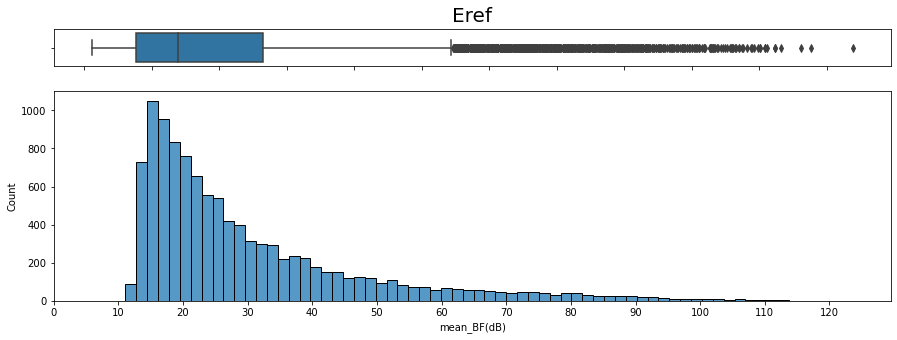

# DD_0

10790 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10790 (True)
	number of loci with meanBF >= 10 :  10790
	number of loci with meanBF >= 15 :  10490
	number of loci with meanBF >= 20 :  7869
	fraction of BF >= 15 :  0.97
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (10821) vs 1% (10490) (diff = 331)


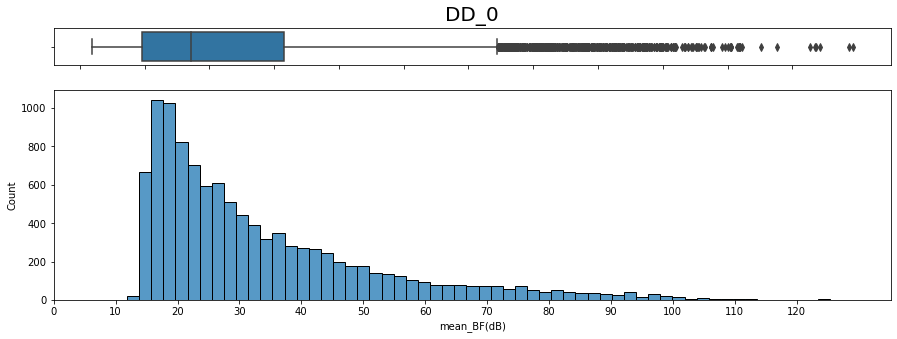

# CMD

8943 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  8943 (True)
	number of loci with meanBF >= 10 :  2621
	number of loci with meanBF >= 15 :  1058
	number of loci with meanBF >= 20 :  534
	fraction of BF >= 15 :  0.12
	fraction of BF >= 10 :  0.29


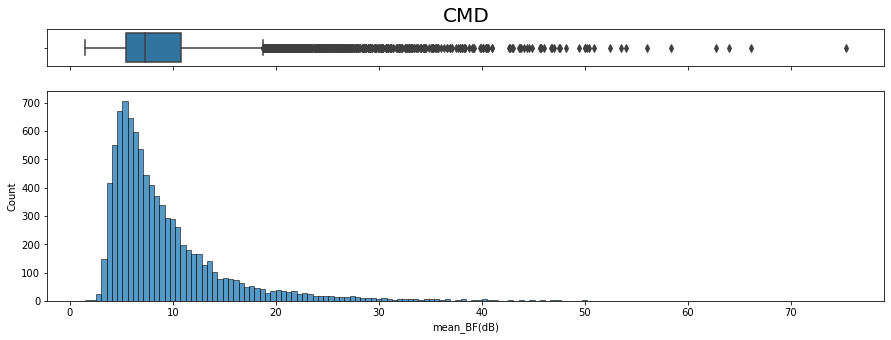

# SHM

8562 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  8561 (False)
	number of loci with meanBF >= 10 :  1858
	number of loci with meanBF >= 15 :  654
	number of loci with meanBF >= 20 :  263
	fraction of BF >= 15 :  0.08
	fraction of BF >= 10 :  0.22


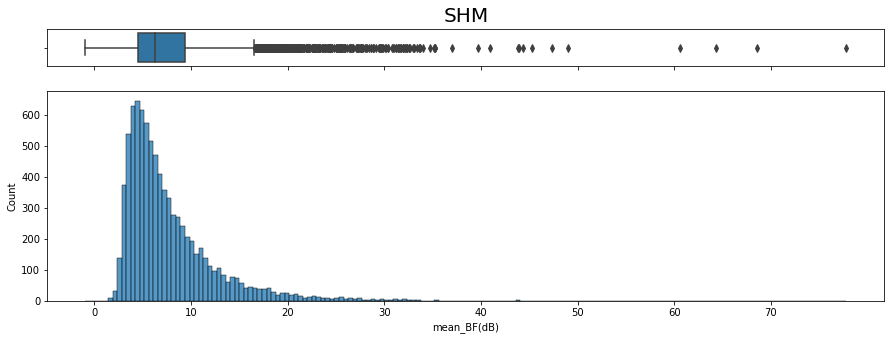

# PAS

9985 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  9985 (True)
	number of loci with meanBF >= 10 :  6339
	number of loci with meanBF >= 15 :  2788
	number of loci with meanBF >= 20 :  1326
	fraction of BF >= 15 :  0.28
	fraction of BF >= 10 :  0.63


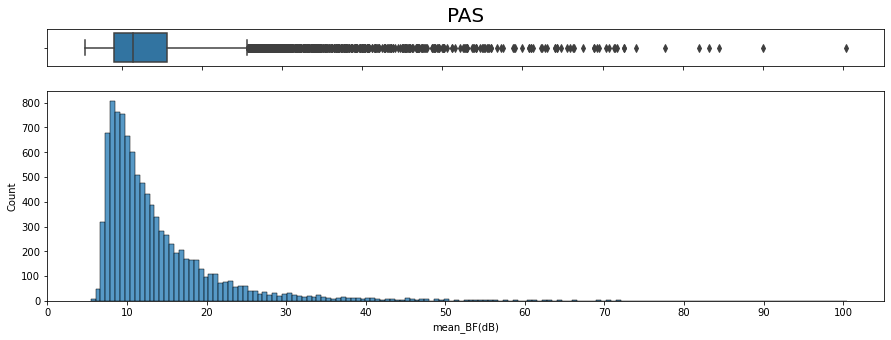

# bFFP

9931 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  9931 (True)
	number of loci with meanBF >= 10 :  5401
	number of loci with meanBF >= 15 :  2875
	number of loci with meanBF >= 20 :  1455
	fraction of BF >= 15 :  0.29
	fraction of BF >= 10 :  0.54


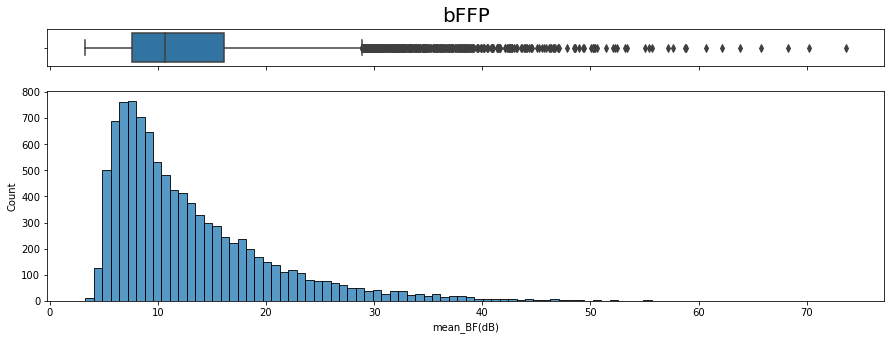

# MAP

10348 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10348 (True)
	number of loci with meanBF >= 10 :  10346
	number of loci with meanBF >= 15 :  6816
	number of loci with meanBF >= 20 :  3690
	fraction of BF >= 15 :  0.66
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (6830) vs 1% (6816) (diff = 14)


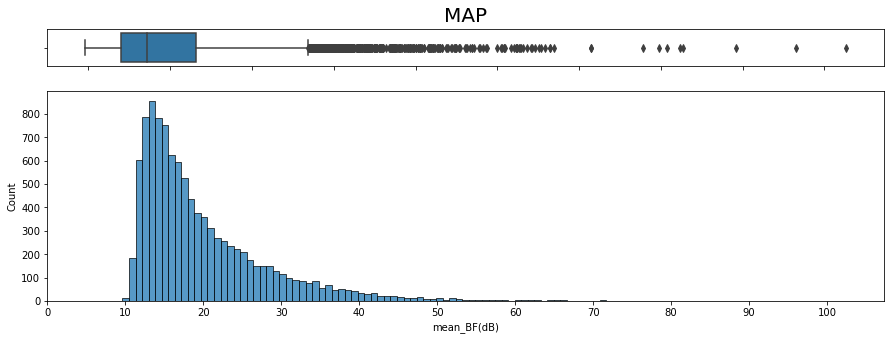

# EMT

10606 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10606 (True)
	number of loci with meanBF >= 10 :  10605
	number of loci with meanBF >= 15 :  8725
	number of loci with meanBF >= 20 :  6216
	fraction of BF >= 15 :  0.82
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (8747) vs 1% (8725) (diff = 22)


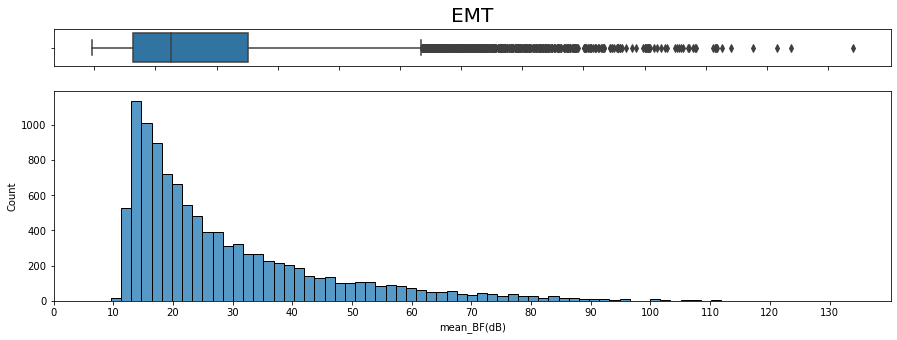

# EXT

8584 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  8584 (True)
	number of loci with meanBF >= 10 :  1633
	number of loci with meanBF >= 15 :  609
	number of loci with meanBF >= 20 :  230
	fraction of BF >= 15 :  0.07
	fraction of BF >= 10 :  0.19


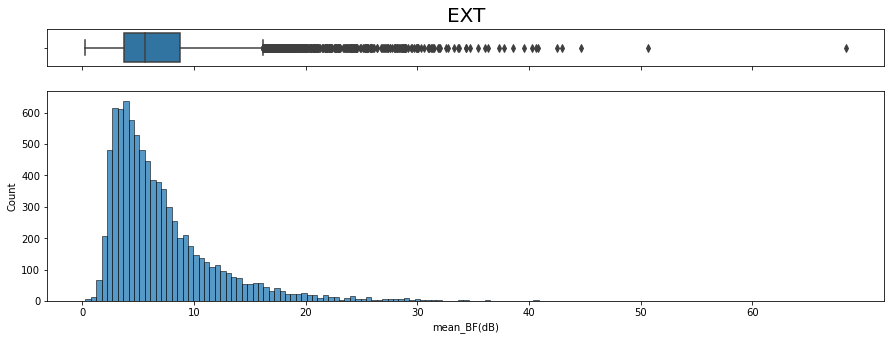

# AHM

9074 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  9074 (True)
	number of loci with meanBF >= 10 :  3168
	number of loci with meanBF >= 15 :  1215
	number of loci with meanBF >= 20 :  540
	fraction of BF >= 15 :  0.13
	fraction of BF >= 10 :  0.35


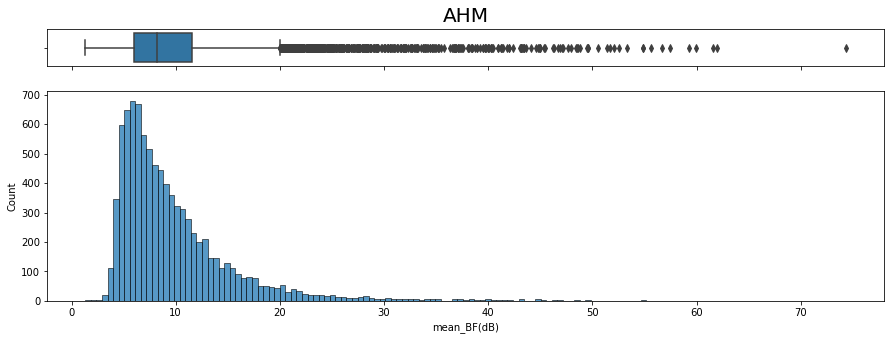

# NFFD

9651 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  9650 (False)
	number of loci with meanBF >= 10 :  4375
	number of loci with meanBF >= 15 :  2138
	number of loci with meanBF >= 20 :  999
	fraction of BF >= 15 :  0.22
	fraction of BF >= 10 :  0.45


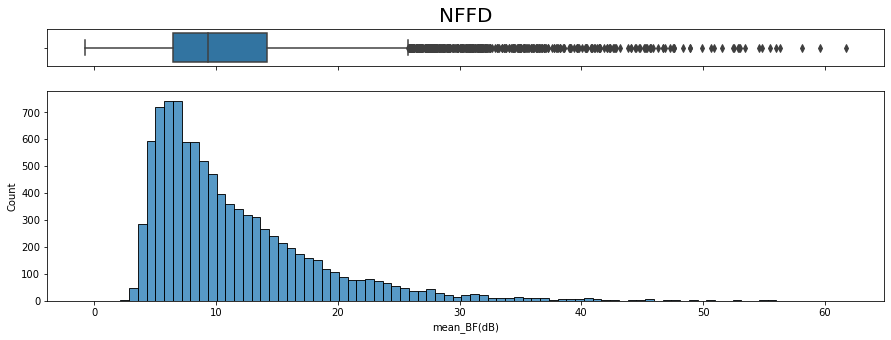

# TD

10328 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10328 (True)
	number of loci with meanBF >= 10 :  10293
	number of loci with meanBF >= 15 :  7248
	number of loci with meanBF >= 20 :  5048
	fraction of BF >= 15 :  0.7
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (7253) vs 1% (7248) (diff = 5)


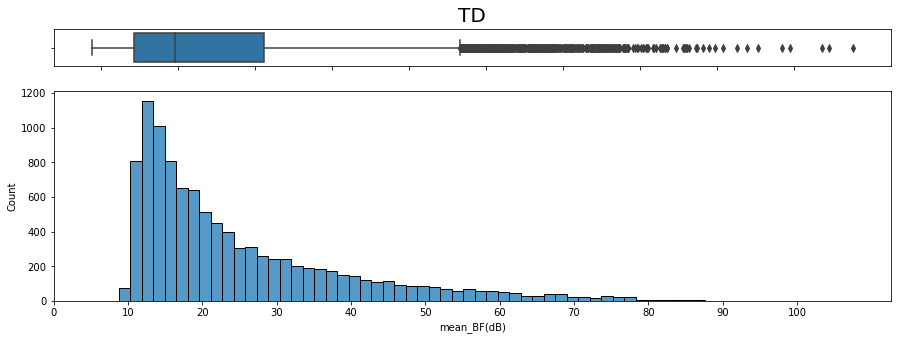

# DD5

10831 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10831 (True)
	number of loci with meanBF >= 10 :  10831
	number of loci with meanBF >= 15 :  9587
	number of loci with meanBF >= 20 :  6611
	fraction of BF >= 15 :  0.89
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (9651) vs 1% (9587) (diff = 64)


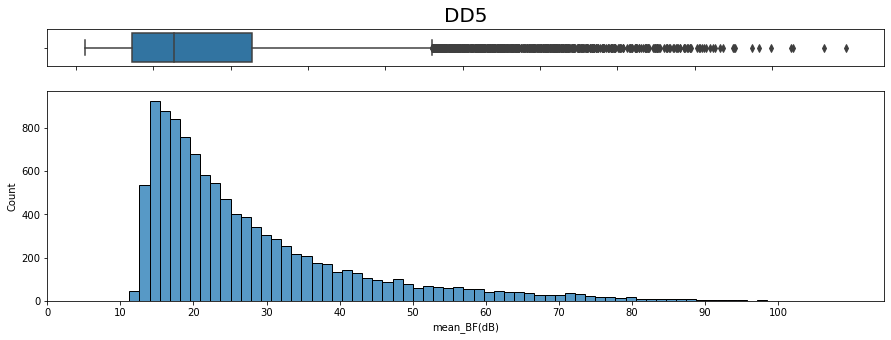

# FFP

10472 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10472 (True)
	number of loci with meanBF >= 10 :  9904
	number of loci with meanBF >= 15 :  6232
	number of loci with meanBF >= 20 :  3856
	fraction of BF >= 15 :  0.6
	fraction of BF >= 10 :  0.95
	not all SNPs with BF >= 15 are consistently in top 1% : full (6236) vs 1% (6232) (diff = 4)


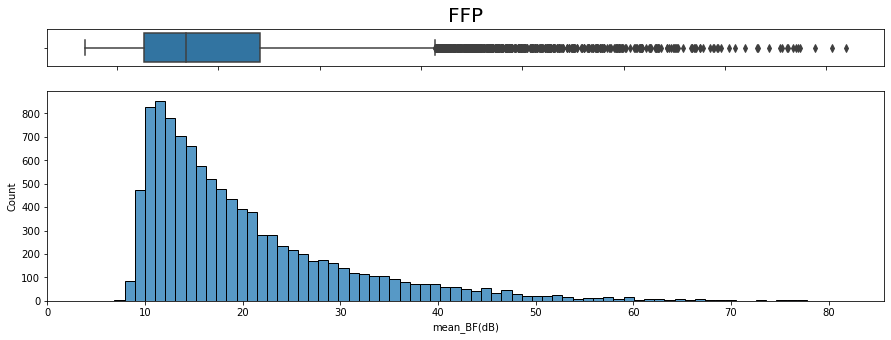

# eFFP

10327 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10327 (True)
	number of loci with meanBF >= 10 :  10240
	number of loci with meanBF >= 15 :  6795
	number of loci with meanBF >= 20 :  4332
	fraction of BF >= 15 :  0.66
	fraction of BF >= 10 :  0.99
	not all SNPs with BF >= 15 are consistently in top 1% : full (6800) vs 1% (6795) (diff = 5)


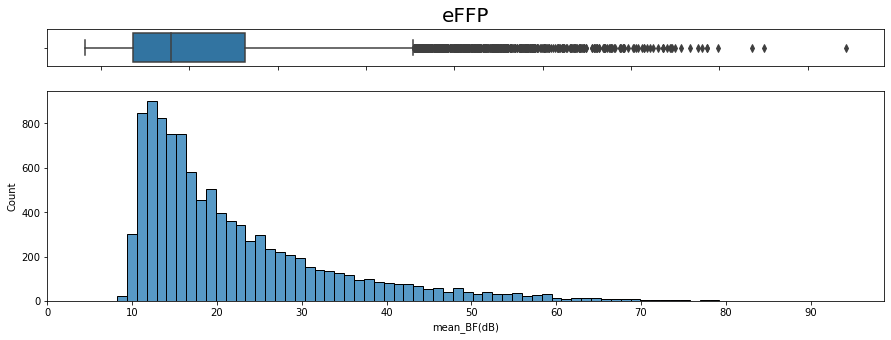

# MSP

9241 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  9241 (True)
	number of loci with meanBF >= 10 :  4623
	number of loci with meanBF >= 15 :  2011
	number of loci with meanBF >= 20 :  912
	fraction of BF >= 15 :  0.22
	fraction of BF >= 10 :  0.5


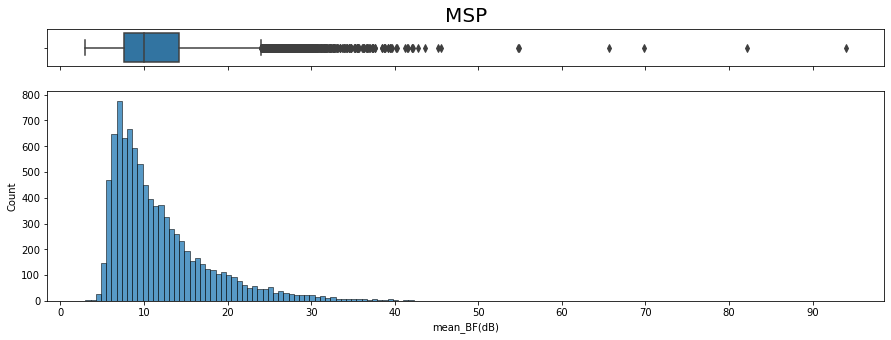

# MAT

10949 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10949 (True)
	number of loci with meanBF >= 10 :  10949
	number of loci with meanBF >= 15 :  10927
	number of loci with meanBF >= 20 :  8707
	fraction of BF >= 15 :  1.0
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (11955) vs 1% (10927) (diff = 1028)
	not all SNPs with BF >= 20 are consistently in top 1% : full (8717) vs 1% (8707) (diff = 10)


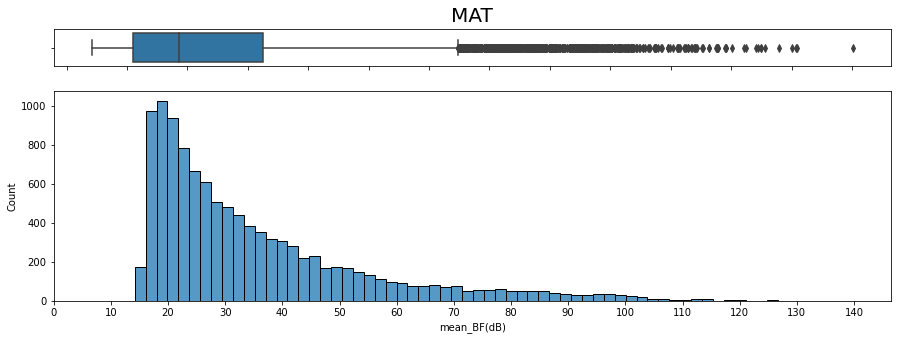

# MWMT

10295 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10295 (True)
	number of loci with meanBF >= 10 :  8960
	number of loci with meanBF >= 15 :  5348
	number of loci with meanBF >= 20 :  3223
	fraction of BF >= 15 :  0.52
	fraction of BF >= 10 :  0.87


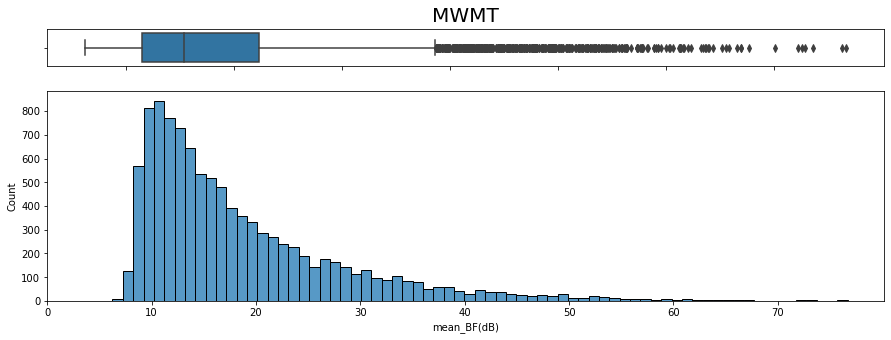

# MCMT

10818 loci consistently ranked in top 1%
	number of loci with meanBF >= 0 :  10818 (True)
	number of loci with meanBF >= 10 :  10818
	number of loci with meanBF >= 15 :  10754
	number of loci with meanBF >= 20 :  8282
	fraction of BF >= 15 :  0.99
	fraction of BF >= 10 :  1.0
	not all SNPs with BF >= 15 are consistently in top 1% : full (11418) vs 1% (10754) (diff = 664)
	not all SNPs with BF >= 20 are consistently in top 1% : full (8284) vs 1% (8282) (diff = 2)


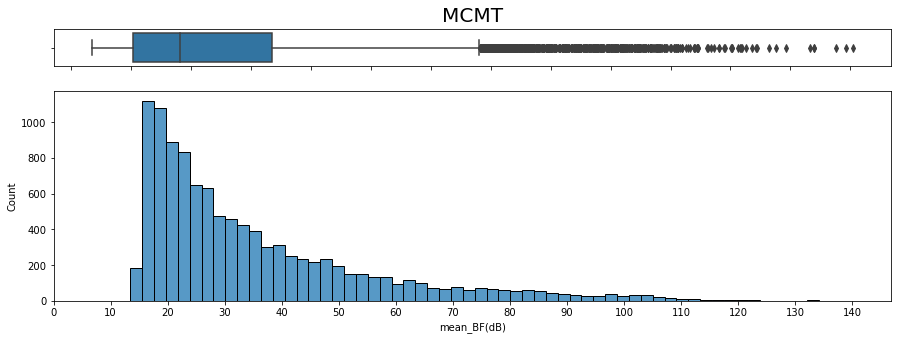




Fraction of meanBF >=15 across envs


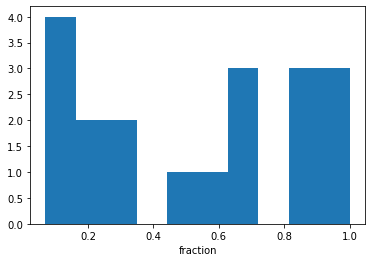

,Eref,DD_0,CMD,SHM,PAS,bFFP,MAP,EMT,EXT,AHM,NFFD,TD,DD5,FFP,eFFP,MSP,MAT,MWMT,MCMT
0,0.9,0.97,0.12,0.08,0.28,0.29,0.66,0.82,0.07,0.13,0.22,0.7,0.89,0.6,0.66,0.22,1.0,0.52,0.99


In [54]:
# for **ONLY** those loci that are consistently ranked in top 1%
# print histograms of bayes factor for each environment
# print fraction of top 1%BFs that have BF ≥ 15 or BF ≥ 20
# also look at histogram for BFs < 100

# also count number of loci across all SNPs that have BF ≥ 15 or BF ≥ 20, print if count doesn't match top 1%
print('\n', ColorText('Stats for loci consistently ranked in top 1%').bold().custom('deepskyblue'))
fracs = defaultdict(dict)
for env,df in envdfs.items():
    df = df[df['rank_consistency_top1perc_for-gte3chains'] == True]
    BFs = df['mean_BF(dB)']
    small10 = sum(BFs >= 10)
    small15 = sum(BFs >= 15)
    small20 = sum(BFs >= 20)
    printmd(f"# {env}")
    print(nrow(df), 'loci consistently ranked in top 1%')
    print('\tnumber of loci with meanBF >= 0 : ', sum(BFs >= 0), "(%s)" % str(sum(BFs >= 0) == nrow(df)))
    print('\tnumber of loci with meanBF >= 10 : ', small10)
    print('\tnumber of loci with meanBF >= 15 : ', small15)
    print('\tnumber of loci with meanBF >= 20 : ', small20)
    frac = round(small15/nrow(df), 2)
    frac2 = round(small10/nrow(df), 2)
    fracs[env][0] = frac
    print('\tfraction of BF >= 15 : ', frac)
    print('\tfraction of BF >= 10 : ', frac2)
    sum15 = sum(envdfs[env]['mean_BF(dB)'] >= 15)
    sum20 = sum(envdfs[env]['mean_BF(dB)'] >= 20)
    if small15 != sum15:
        text = '\tnot all SNPs with BF >= 15 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum15}) vs 1% ({small15}) (diff = {sum15 - small15})").warn().bold())
    if small20 != sum20:
        text = '\tnot all SNPs with BF >= 20 are consistently in top 1%'
        print(ColorText(f"{text} : full ({sum20}) vs 1% ({small20}) (diff = {sum20 - small20})").warn().bold())

    histo_box(data=df, col='mean_BF(dB)', title=env, figsize=(15,5))

#     plt.hist(BFs[BFs<100], bins=100)
#     plt.title('number of loci with BF < 100')
#     plt.show()
    print('\n')

# create histogram for fraction of SNPs with BF>=15 in consistent top 1% across environments
print(ColorText('\nFraction of meanBF >=15 across envs').bold())
fracdf = pd.DataFrame(fracs)
plt.hist(fracdf.loc[0,:])
plt.xlabel('fraction')
plt.show()
fracdf